# Attention: Transformer Block na kolorowaniu symboli

W tym zadaniu zbudujemy **blok Transformera**, który nauczy się prostej reguły:
**wszystkie tokeny tego samego symbolu w sekwencji mają ten sam kolor**.

### Koncept

Mamy **10 symboli**: ▲ ♥ ■ ★ ● ◆ ▼ ♠ ♣ ✚

Każdy symbol może mieć jeden z **5 kolorów** (czerwony, niebieski, zielony, żółty, fioletowy) lub być **zamaskowany** (kolor=0, nieznany).

Kodowanie tokenu: `token = symbol_id * 6 + color_id`, gdzie:
- `symbol_id` ∈ {0, 1, ..., 9}
- `color_id` ∈ {0, 1, 2, 3, 4, 5} (0 = zamaskowany/nieznany)
- Łączny rozmiar słownika: **60** tokenów

### Reguła
Każda sekwencja zawiera 10 tokenów. Symbole mogą się powtarzać, a **wszystkie wystąpienia tego samego symbolu mają zawsze ten sam kolor**. Część tokenów jest zamaskowana (kolor=0).

### Cel
Model musi przewidzieć **prawdziwy kolor (1-5)** dla każdego zamaskowanego tokenu. Kluczowa intuicja: model musi nauczyć się **patrzeć na inne tokeny tego samego symbolu** (które nie są zamaskowane), żeby odgadnąć kolor — dokładnie to, do czego służy **mechanizm attention**!

## Kryterium oceny

Jakość rozwiązania mierzymy za pomocą **accuracy** (dokładności) na zamaskowanych tokenach zbioru testowego.

### Punktacja

* jeśli accuracy ≥ 95% → **1 punkt**
* jeśli accuracy ≤ 85% → **0 punktów**
* w przedziale 85–95% → punkty skalowane **liniowo**

$$
\text{punkty}(\text{acc}) =
\begin{cases}
1, & \text{gdy } \text{acc} \ge 0.95,\\
0, & \text{gdy } \text{acc} \le 0.85,\\
\dfrac{\text{acc} - 0.85}{0.10}, & \text{w przeciwnym razie.}
\end{cases}
$$

## Format zgłoszenia

Rozwiązaniem jest plik `solution.npz` z jedną tablicą:

```python
np.savez("solution.npz", predictions=pred_colors)  # shape: (N_masked,), wartości 1-5
```

gdzie `N_masked` to łączna liczba zamaskowanych tokenów w zbiorze testowym (po kolei, sekwencja po sekwencji).

In [1]:
import random

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import Tensor
from torch.utils.data import DataLoader, TensorDataset

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Urządzenie: {DEVICE}")

Urządzenie: cpu


---
## 1. Wczytywanie danych

Wczytujemy przygotowane sekwencje z pliku `data.npz`.

---

In [4]:
NUM_SYMBOLS = 10
NUM_COLORS = 5  # kolory 1-5; 0 = zamaskowany
VOCAB_SIZE = NUM_SYMBOLS * (NUM_COLORS + 1)  # 60
SEQ_LEN = 10

SYMBOLS = ["▲", "♥", "■", "★", "●", "◆", "▼", "♠", "♣", "✚"]
COLOR_NAMES = ["none", "czerwony", "niebieski", "zielony", "żółty", "fioletowy"]
COLOR_MAP = {
    0: "gray",
    1: "red",
    2: "blue",
    3: "green",
    4: "goldenrod",
    5: "purple",
}

data = np.load("data.npz")

train_tokens = torch.from_numpy(data["train_tokens"]).long()
train_colors = torch.from_numpy(data["train_colors"]).long()
train_masks = torch.from_numpy(data["train_masks"]).bool()

val_tokens = torch.from_numpy(data["val_tokens"]).long()
val_colors = torch.from_numpy(data["val_colors"]).long()
val_masks = torch.from_numpy(data["val_masks"]).bool()

test_tokens = torch.from_numpy(data["test_tokens"]).long()
test_masks = torch.from_numpy(data["test_masks"]).bool()

print(f"Train: {len(train_tokens)} sekwencji, zamaskowane tokeny: {train_masks.sum().item()}")
print(f"Val:   {len(val_tokens)} sekwencji, zamaskowane tokeny: {val_masks.sum().item()}")
print(f"Test:  {len(test_tokens)} sekwencji, zamaskowane tokeny: {test_masks.sum().item()}")

print(f"\nPrzykładowa sekwencja (tokeny): {train_tokens[0].tolist()}")
print(f"Maska:                          {train_masks[0].tolist()}")
print(f"Prawdziwe kolory:               {train_colors[0].tolist()}")

Train: 5000 sekwencji, zamaskowane tokeny: 10000
Val:   1000 sekwencji, zamaskowane tokeny: 2000
Test:  1000 sekwencji, zamaskowane tokeny: 2000

Przykładowa sekwencja (tokeny): [7, 6, 5, 0, 40, 40, 7, 40, 5, 31]
Maska:                          [False, True, False, True, False, False, False, False, False, False]
Prawdziwe kolory:               [1, 1, 5, 5, 4, 4, 1, 4, 5, 1]


In [5]:
train_ds = TensorDataset(train_tokens, train_colors, train_masks)
val_ds = TensorDataset(val_tokens, val_colors, val_masks)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=256, shuffle=False)

## 2. Wizualizacja

Zobaczmy jak wyglądają nasze sekwencje — kolorowe symbole z zamaskowanymi pozycjami.

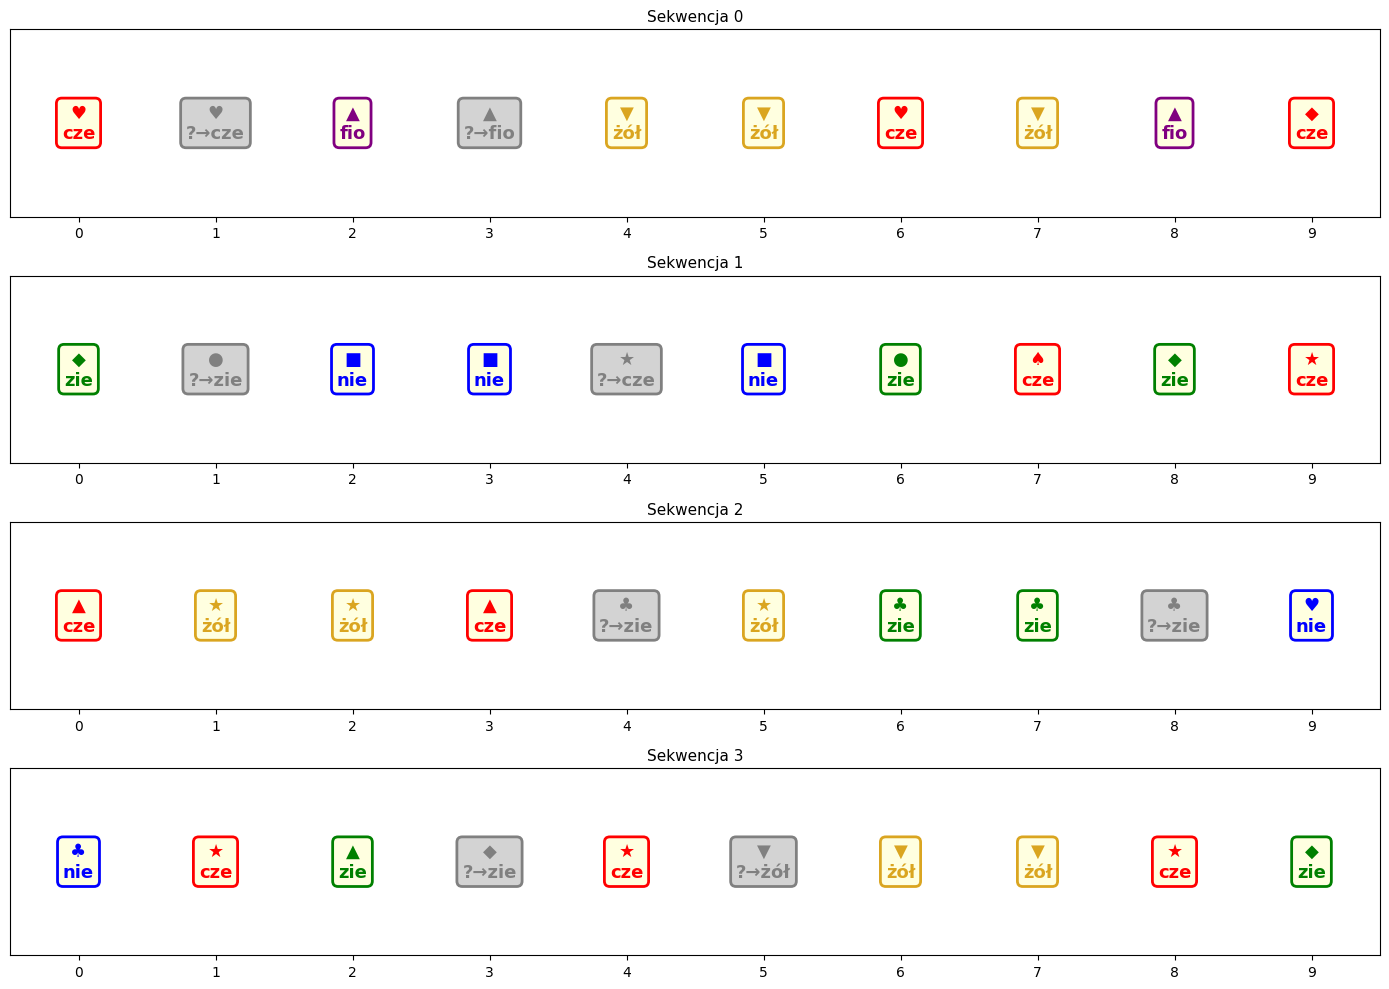

In [6]:
def decode_token(token_id: int) -> tuple[int, int]:
    """Dekoduje token_id na (symbol_id, color_id)."""
    symbol_id = token_id // 6
    color_id = token_id % 6
    return symbol_id, color_id


def visualize_sequences(tokens: Tensor, masks: Tensor, true_colors: Tensor | None = None, n: int = 4) -> None:
    """Wyświetla sekwencje z kolorowymi symbolami. Zamaskowane tokeny pokazane na szaro ze znakiem '?'."""
    fig, axes = plt.subplots(n, 1, figsize=(14, 2.5 * n))
    if n == 1:
        axes = [axes]
    
    for idx, ax in enumerate(axes):
        seq_len = tokens.shape[1]
        ax.set_xlim(-0.5, seq_len - 0.5)
        ax.set_ylim(-0.5, 0.5)
        ax.set_yticks([])
        ax.set_xticks(range(seq_len))
        ax.set_title(f"Sekwencja {idx}", fontsize=11)
        
        for pos in range(seq_len):
            tok = tokens[idx, pos].item()
            is_masked = masks[idx, pos].item()
            sym_id, col_id = decode_token(tok)
            symbol = SYMBOLS[sym_id]
            
            if is_masked:
                color = "gray"
                label = f"{symbol}\n?"
                if true_colors is not None:
                    true_col = true_colors[idx, pos].item()
                    label = f"{symbol}\n?→{COLOR_NAMES[true_col][:3]}"
            else:
                color = COLOR_MAP[col_id]
                label = f"{symbol}\n{COLOR_NAMES[col_id][:3]}"
            
            ax.text(pos, 0, label, ha="center", va="center",
                    fontsize=13, fontweight="bold", color=color,
                    bbox=dict(boxstyle="round,pad=0.3",
                              facecolor="lightyellow" if not is_masked else "lightgray",
                              edgecolor=color, linewidth=2))
    
    plt.tight_layout()
    plt.show()


visualize_sequences(train_tokens, train_masks, train_colors, n=4)

## 3. Model

Budujemy model oparty o **blok Transformera**. Składa się z:

1. **`calc_attention(Q, K, V)`** — oblicza scaled dot-product attention
2. **`TransformerBlock`** — Multi-head attention (z jedną głową) + feed-forward + LayerNorm
3. **`EmbeddingModel`** — embedding tokenów
4. **`TransformerModel`** — łączy embedding + transformer block + głowa wyjściowa

### TODO: Uzupełnij poniższe klasy

In [7]:
def calc_attention(Q: Tensor, K: Tensor, V: Tensor) -> tuple[Tensor, Tensor]:
    """
    Argumenty:
        Q: (batch, seq_len, d_model)
        K: (batch, seq_len, d_model)
        V: (batch, seq_len, d_model)
    Zwraca:
        output: (batch, seq_len, d_model)
        attention_weights: (batch, seq_len, seq_len)
    """

    # TODO
    return output, attention_weights


In [8]:
class TransformerBlock(nn.Module):
    """Pojedynczy blok transformera: self-attention + feed-forward + residual + LayerNorm."""

    def __init__(self, d_model: int, d_ff: int = 128) -> None:
        super().__init__()
        # TODO
        # self.W_Q =
        # self.W_K =
        # self.W_V =
        #
        # self.norm1 =
        # self.norm2 =
        #
        # self.ff = nn.Sequential(
        #     ...
        # )

    def forward(self, x: Tensor) -> tuple[Tensor, Tensor]:
        """
        Argumenty:
            x: (batch, seq_len, d_model)
        Zwraca:
            output: (batch, seq_len, d_model)
            attention_weights: (batch, seq_len, seq_len)
        """
        # TODO
        return output, attn_weights

In [9]:
class EmbeddingModel(nn.Module):
    """Embedding tokenów"""
    
    def __init__(self, vocab_size: int, d_model: int) -> None:
        super().__init__()
        self.token_emb = nn.Embedding(vocab_size, d_model)
    
    def forward(self, tokens: Tensor) -> Tensor:
        """Argumenty: tokens: (batch, seq_len), Zwraca: (batch, seq_len, d_model)"""
        # TODO
        return output

In [10]:
class TransformerModel(nn.Module):
    """Pełny model: Embedding + TransformerBlock + głowa wyjściowa (d_model -> n_colors).
    
    Przewiduje kolor (1-5) dla każdej pozycji. Interesują nas tylko zamaskowane pozycje,
    ale model powinien zwrócić wynik dla każdej pozycji. Zwracamy logits (przed softmaxem).
    Przez to, że kolory są liczone od 1 do 5, należy później (do wyniku argmax z tego, co zwrócił forward) dodać +1.
    """
    
    def __init__(self, vocab_size: int = 60, d_model: int = 64, n_colors: int = 5) -> None:
        super().__init__()
        self.embedding = EmbeddingModel(vocab_size, d_model)
        self.transformer = TransformerBlock(d_model)
        self.output_head = nn.Linear(d_model, n_colors)  # przewiduje klasy 0..4 → kolory 1..5
    
    def forward(self, tokens: Tensor) -> tuple[Tensor, Tensor]:
        """
        Argumenty:
            tokens: (batch, seq_len) - identyfikatory tokenów
        Zwraca:
            logits: (batch, seq_len, n_colors)
            attention_weights: (batch, seq_len, seq_len)
        """
        # TODO
        return logits, attn_weights

## 4. Trening

Trenujemy model z `CrossEntropyLoss` **tylko na zamaskowanych pozycjach**.

### TODO: Uzupełnij pętlę treningową

In [11]:
def evaluate(model: nn.Module, loader: DataLoader) -> float:
    """Oblicza dokładność na zamaskowanych pozycjach."""
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for tokens, colors, masks in loader:
            tokens = tokens.to(DEVICE)
            colors = colors.to(DEVICE)
            masks = masks.to(DEVICE)
            
            logits, _ = model(tokens)
            
            # Ewaluuj tylko na zamaskowanych pozycjach
            pred = logits.argmax(dim=-1) + 1  # konwertuj 0-4 → 1-5
            
            masked_pred = pred[masks]
            masked_true = colors[masks]
            
            correct += (masked_pred == masked_true).sum().item()
            total += masks.sum().item()
    
    return correct / total if total > 0 else 0.0


def train_model(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader, epochs: int = 20, lr: float = 1e-3) -> None:
    """Trenuje model transformera."""
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0.0
        n_batches = 0
        
        for tokens, colors, masks in train_loader:
            tokens = tokens.to(DEVICE)
            colors = colors.to(DEVICE)
            masks = masks.to(DEVICE)
            
            optimizer.zero_grad()
            logits, _ = model(tokens)

            # TODO:
            # Strata tylko na zamaskowanych pozycjach
            # kształt logits: (batch, seq_len, n_colors)
            # targety: colors[masks] - 1 (konwertuj 1-5 → 0-4 dla CrossEntropyLoss)

            # loss = ...
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            n_batches += 1
        
        if epoch % 5 == 0 or epoch == 1:
            train_acc = evaluate(model, train_loader)
            val_acc = evaluate(model, val_loader)
            print(f"Epoka {epoch:3d} | Loss: {total_loss/n_batches:.4f} | "
                  f"Train acc: {train_acc:.3f} | Val acc: {val_acc:.3f}")


model = TransformerModel(vocab_size=VOCAB_SIZE, d_model=64, n_colors=NUM_COLORS).to(DEVICE)
print(f"Parametry modelu: {sum(p.numel() for p in model.parameters()):,}")

train_model(model, train_loader, val_loader, epochs=30)

Parametry modelu: 33,477
Epoka   1 | Loss: 1.0660 | Train acc: 0.930 | Val acc: 0.924
Epoka   5 | Loss: 0.0022 | Train acc: 1.000 | Val acc: 1.000
Epoka  10 | Loss: 0.0006 | Train acc: 1.000 | Val acc: 1.000
Epoka  15 | Loss: 0.0003 | Train acc: 1.000 | Val acc: 1.000
Epoka  20 | Loss: 0.0002 | Train acc: 1.000 | Val acc: 1.000
Epoka  25 | Loss: 0.0001 | Train acc: 1.000 | Val acc: 1.000
Epoka  30 | Loss: 0.0001 | Train acc: 1.000 | Val acc: 1.000


## 5. Wizualizacja Attention

Zobaczmy na co "patrzy" model — heatmapa attention powinna pokazywać, że zamaskowane tokeny skupiają uwagę na **tokenach tego samego symbolu** (z widocznym kolorem).


--- Sekwencja 0 ---


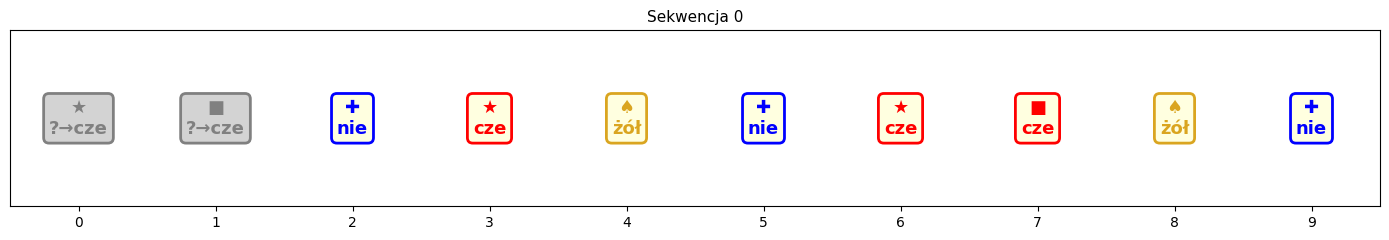

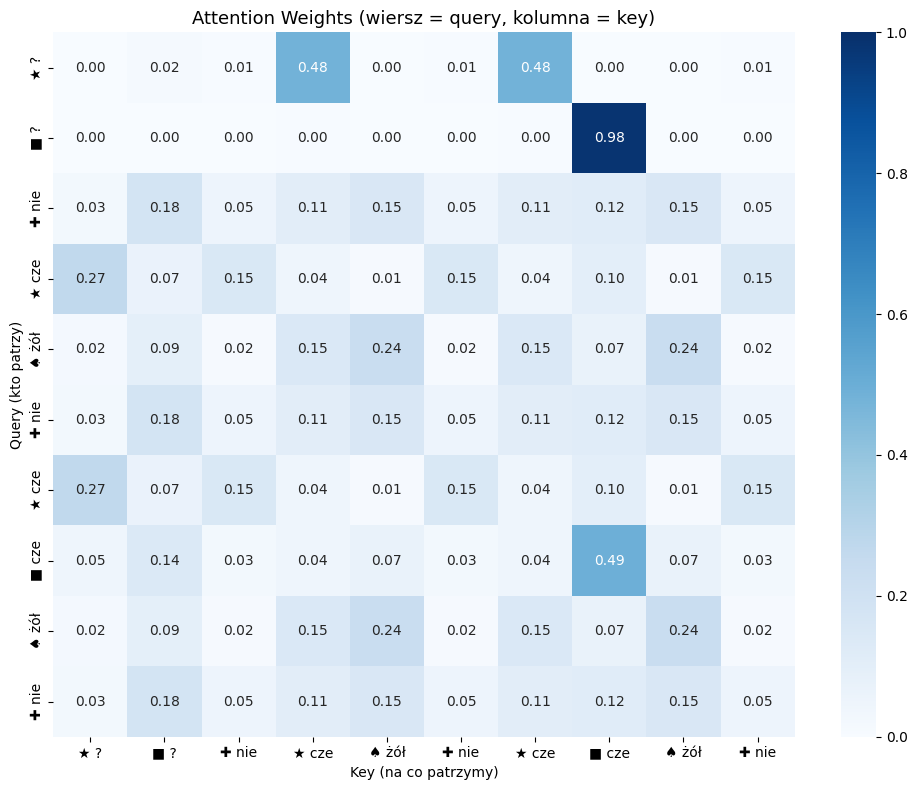


--- Sekwencja 1 ---


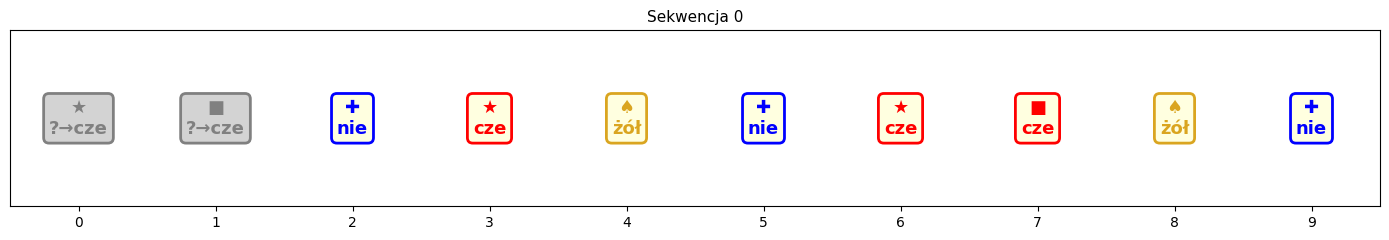

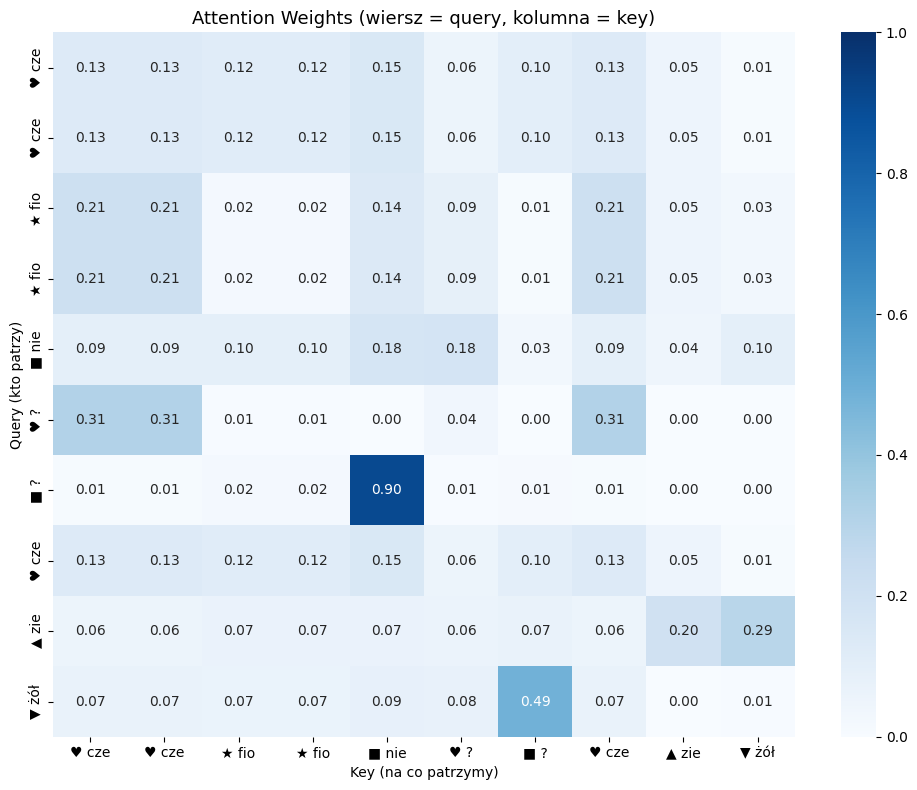


--- Sekwencja 2 ---


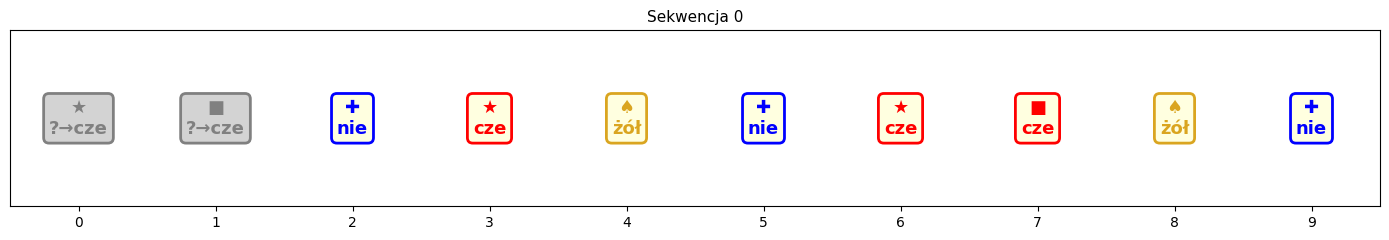

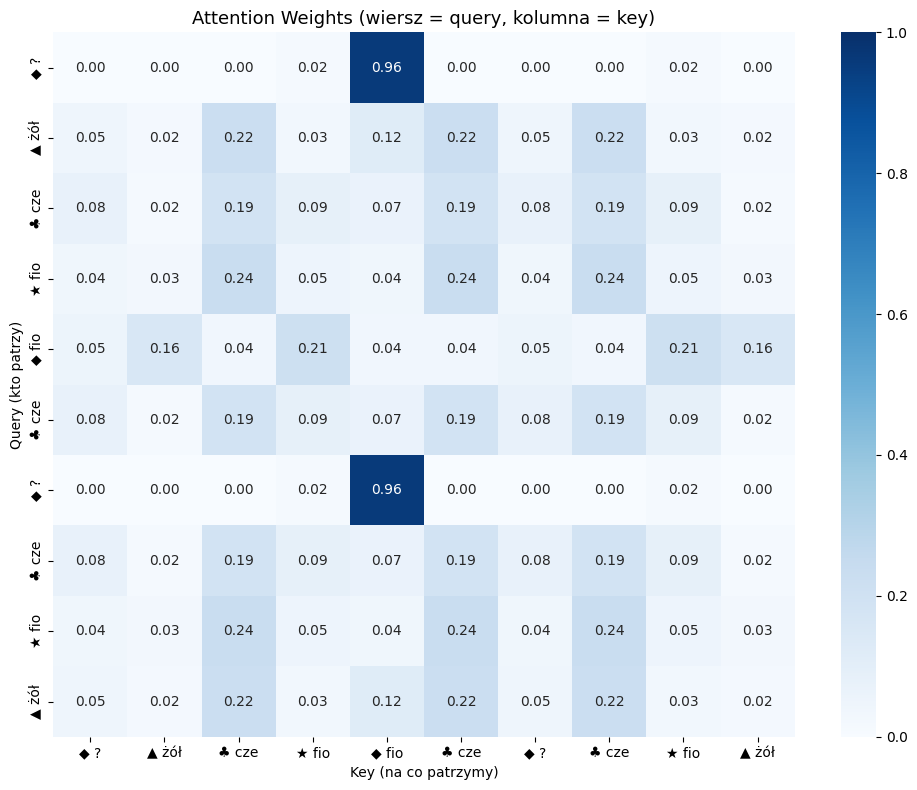

In [12]:
def visualize_attention(model: nn.Module, tokens: Tensor, masks: Tensor, seq_idx: int = 0) -> None:
    """Wizualizuje wagi attention dla pojedynczej sekwencji."""
    model.eval()
    
    seq_tokens = tokens[seq_idx:seq_idx+1].to(DEVICE)
    with torch.no_grad():
        _, attn_weights = model(seq_tokens)
    
    seq_len = tokens.shape[1]
    attn = attn_weights[0, :seq_len, :seq_len].cpu().numpy()
    
    # Stwórz etykiety
    labels = []
    for pos in range(seq_len):
        tok = tokens[seq_idx, pos].item()
        sym_id, col_id = decode_token(tok)
        is_masked = masks[seq_idx, pos].item()
        symbol = SYMBOLS[sym_id]
        if is_masked:
            labels.append(f"{symbol} ?")
        else:
            labels.append(f"{symbol} {COLOR_NAMES[col_id][:3]}")
    
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(attn, xticklabels=labels, yticklabels=labels,
                cmap="Blues", annot=True, fmt=".2f", ax=ax,
                vmin=0, vmax=1)
    ax.set_title("Attention Weights (wiersz = query, kolumna = key)", fontsize=13)
    ax.set_xlabel("Key (na co patrzymy)")
    ax.set_ylabel("Query (kto patrzy)")
    plt.tight_layout()
    plt.show()


# Pokaż attention dla kilku przykładów
for i in range(3):
    print(f"\n--- Sekwencja {i} ---")
    visualize_sequences(val_tokens, val_masks, val_colors, n=1)
    visualize_attention(model, val_tokens, val_masks, seq_idx=i)

## 6. Predykcja na zbiorze testowym i zapis rozwiązania

In [13]:
def predict_test(model: nn.Module, test_tokens: Tensor, test_masks: Tensor) -> np.ndarray:
    """Generuje predykcje dla wszystkich zamaskowanych tokenów testowych."""
    model.eval()
    all_preds = []
    
    batch_size = 256
    n = len(test_tokens)
    
    with torch.no_grad():
        for start in range(0, n, batch_size):
            end = min(start + batch_size, n)
            tokens_batch = test_tokens[start:end].to(DEVICE)
            masks_batch = test_masks[start:end]
            
            logits, _ = model(tokens_batch)
            
            pred = logits.argmax(dim=-1).cpu() + 1  # 0-4 -> 1-5
            
            # Wyciągnij predykcje zamaskowanych pozycji po kolei
            masked_preds = pred[masks_batch]
            all_preds.append(masked_preds.numpy())
    
    return np.concatenate(all_preds)


predictions = predict_test(model, test_tokens, test_masks)
print(f"Liczba predykcji: {len(predictions)}")
print(f"Rozkład kolorów: {np.bincount(predictions, minlength=6)[1:]}")
print(f"Przykładowe predykcje: {predictions[:20]}")

Liczba predykcji: 2000
Rozkład kolorów: [398 362 423 414 403]
Przykładowe predykcje: [4 4 1 5 5 4 3 3 2 2 2 5 1 2 3 4 2 3 4 4]


In [14]:
# Zapisz rozwiązanie
np.savez("solution.npz", predictions=predictions)
print(f"Zapisano solution.npz ({len(predictions)} predykcji)")

Test accuracy: 1.0000
Zapisano solution.npz (2000 predykcji)
